# Exercise 5 - Maschinelles Lernen: Grundlagen und Algorithmen
In this exercise you will implement two generative models: First a Gaussian mixture model (GMM, 7 Points) and second, a Denoising Diffusion Probabillistic Model (DDPM, 11 Points).

As usual, we start by importing some packages and loading our data.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from typing import Tuple

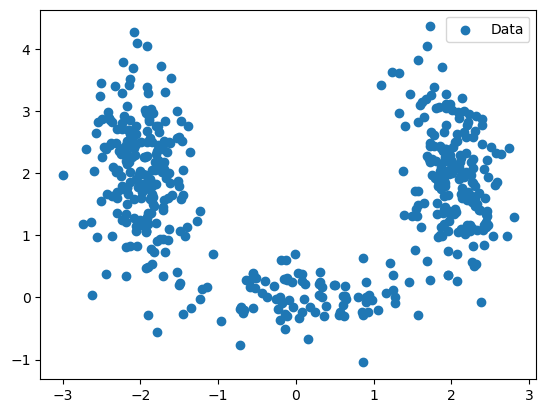

In [2]:
data = np.load("samples_u.npy")
seed = 123
k = 3

np.random.seed(seed)

plt.scatter(data[:,0], data[:,1], label='Data')
plt.legend()
plt.show()

## 1.) Expectation Maximization for Gaussian Mixture Models (7 Points)
In this exercise, we implement the expectation maximization (EM) algorithm to fit a Gaussian mixture model (GMM) to data. We start with an implementation of the log-density of a single Gaussian. We already saw an implementation of this in the first exercise and noted there that it was not the "proper" way of doing it. Here, we provide a better implementation. Compare the two implementations.

In [3]:
def gaussian_log_density(samples: np.ndarray, mean: np.ndarray, covariance: np.ndarray) -> np.ndarray:
    """
    Computes the log-density of samples under a Gaussian distribution in a stable and efficient manner.
    :param samples: samples (shape: [N x dim])
    :param mean: mean of the distribution (shape: [dim])
    :param covariance: covariance of the distribution (shape: [dim x dim])
    :return: log N(x | mean, covariance) (shape: [N])
    """
    dim = mean.shape[0]

    # Recall:
    #  log N(x | mu, Sigma) = - 0.5 * dim * log(2pi)
    #                         - 0.5 * log det Sigma
    #                         - 0.5 * (x - mu)^T Sigma^(-1) (x - mu)

    # Everything is more stable using the Cholesky decomposition!
    #  Sigma = L^T L, where L is lower triangular
    chol_covariance = np.linalg.cholesky(covariance)

    # compute constant term: -0.5 * dim * log(2pi)
    const_term = dim * np.log(2 * np.pi)  # float

    # compute log-determinant: -0.5 * log det Sigma = -0.5 * log prod diag(L)
    logdet_term = 2 * np.sum(np.log(np.diagonal(chol_covariance) + 1e-25))  # (N,)

    # compute exponential term:
    #  (x - mu)^T Sigma^(-1) (x - mu) = ((x - mu) L^(-1))^T * (L^(-1) (x - mu))
    diff = samples - mean[None, :]  # shape (N, dim)
    sol = scipy.linalg.solve_triangular(chol_covariance, diff.T, lower=True).T  # (N, dim)
    exp_term = np.sum(np.square(sol), axis=-1)  # (N,)
    return -0.5 * (const_term + logdet_term + exp_term)

We also provide some plotting functionaliy for 2D GMMs:

In [4]:
COLORS = ['tab:blue', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey',
          'tab:olive', 'tab:cyan']

def visualize_2d_gmm(samples, weights, means, covs, title):
    """Visualize the model and the samples."""
    plt.figure(figsize=[7,7])
    plt.title(title)
    plt.scatter(samples[:, 0], samples[:, 1], label="Samples", c=COLORS[0])

    for i in range(means.shape[0]):
        (largest_eigval, smallest_eigval), eigvec = np.linalg.eig(covs[i])
        phi = -np.arctan2(eigvec[0, 1], eigvec[0, 0])

        plt.scatter(means[i, 0:1], means[i, 1:2], marker="x", c=COLORS[i+1])

        a = 2.0 * np.sqrt(largest_eigval)
        b = 2.0 * np.sqrt(smallest_eigval)

        ellipse_x_r = a * np.cos(np.linspace(0, 2 * np.pi, num=200))
        ellipse_y_r = b * np.sin(np.linspace(0, 2 * np.pi, num=200))

        R = np.array([[np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]])
        r_ellipse = np.array([ellipse_x_r, ellipse_y_r]).T @ R
        plt.plot(means[i, 0] + r_ellipse[:, 0], means[i, 1] + r_ellipse[:, 1],
                 label="Component {:02d}, Weight: {:0.4f}".format(i, weights[i]), c=COLORS[i+1])
    plt.legend()

For this exercise, you need to implement 4 functions:
- The log joint densities $\log \left( p(x | z = k) p(z = k) \right)$ for all components $k$ of a GMM,
- the log-likelihood $\log p(x) = \log \sum_k p(x | z = k) p(z = k) $ of a GMM,
- the E-Step of the EM algorithm for GMMs,
- the M-Step of the EM algorithm for GMMs.

***Hints***:
- for-loops are only allowed in ```log_joint_densities()```!
- Consider using the ```logsumexp```-trick for a stable implementation of ```gmm_log_likelihood()```.

In [5]:
def compute_log_joint_densities(samples: np.ndarray, weights: np.ndarray, means: np.ndarray, covariances: np.ndarray) -> np.ndarray:
    """
    Computes the log joint densities of samples under a GMM, given model parameters.
    :param samples: samples (shape: [N x dim])
    :param weights: mixture weights, i.e., p(z) (shape: [num_components])
    :param means: component means, i.e., means of p(x|z) (shape: [num_components, dim])
    :param covariances: component covariances, i.e., means of p(x|z) (shape: [num_components, dim, dim])
    :return: log joint densities, i.e., log (p(x|z = k)p(z = k)) (shape: [N, k])
    """
    ############################################################
    # TODO: Compute the log joint densities log ( p(x_n | z = k) p(z = k) ) of a GMM.

    ## SOLUTION ################################################
    # compute log component densities: log p(x_n | z = k) = log N(x_n | mu_k, cov_k)
    log_component_densities = []
    for i in range(len(weights)):
        log_component_densities.append(gaussian_log_density(samples, means[i], covariances[i]))
    log_component_densities = np.stack(log_component_densities, -1) # shape (N, k)

    # compute log joint densities: log p(x_n, z = k) = log p(x_n | z = k) + log p(z = k)
    log_joint_densities = log_component_densities + np.log(weights[None, :])  # shape (N, k)
    ############################################################

    return log_joint_densities

def compute_gmm_log_likelihood(log_joint_densities: np.ndarray) -> np.ndarray:
    """
    Computes the log-likelihood of a GMM based on the log joint densities.
    :param log_joint_densities: log joint densities, i.e., log p(x | z = k) p(z = k) (shape: [N, k])
    :param weights: mixture weights, i.e., p(z) (shape: [num_components])
    :return: log-likelihood, i.e., log p(x_n) = log sum_k p(x_n | z = k) p(z = k) (shape: [N])
    """
    ############################################################
    # TODO: Implement the log-likelihood log p(x_n) = log sum_k p(x_n | z = k) p(z = k) for GMMs.

    ## SOLUTION ################################################
    # 1.) without log_sum_exp trick
    # marginal_densities = np.log(np.sum(np.exp(log_joint_densities), axis=1))

    # 2.) with log_sum_exp trick
    # We would like to avoid computing the bare densities np.exp(log_joint_densities)
    #  and rather stay in log-space to avoid numerical underflow (p(x_n) might be
    #  numerically zero and hence log p(x_n) might be undefined).
    # Thus, subtract a_n := max_k log p(x_n, z = k) from the log p(x_n, z = k), s.t.,
    #  log sum_k exp log p(x_n, z=k)
    #  = log sum_k exp (log p(x_n, z=k) - a_n + a_n)
    #  = log [ exp a_n * sum_k exp (log p(x_n, z=k) - a_n) ]
    #  = a_n + log sum_k exp (log p(x_n, z=k) - a_n)
    # Note that we avoid numerical underflow as one term in the sum is ensured to equal 1.
    a = np.max(log_joint_densities, axis=1, keepdims=True)  # shape (N, 1)
    marginal_densities = np.squeeze(a) + np.log(np.sum(np.exp(log_joint_densities - a), 1))  # shape (N,)
    ############################################################

    return marginal_densities


def e_step(samples: np.ndarray, weights: np.ndarray, means: np.ndarray, covariances: np.ndarray) -> np.ndarray:
    """
    E-Step of EM for fitting GMMs. Computes responsibilities, p(z|x), given samples and model parameters.
    :param samples: samples on which to compute the responsibilities (shape: [N, dim])
    :param weights: weights (i.e., p(z)) of model (shape: [num_components])
    :param means: means of components p(x|z) (shape: [num_components, dim])
    :param covariances: covariances of model components p(x|z) (shape: [num_components, dim, dim])
    :return: responsibilities p(z|x) (shape: [N x num_components])
    """
    ############################################################
    # TODO Implement the E-Step of EM for GMMs.

    ## SOLUTION ################################################
    log_joint_densities = compute_log_joint_densities(samples, weights, means, covariances)  # shape (N, k)

    # compute log p(z = k | x_n) = log p(x_n, z = k) - log p(x_n)
    log_responsibilities = log_joint_densities - compute_gmm_log_likelihood(log_joint_densities)[:, None]  # shape (N, k)
    ############################################################

    return np.exp(log_responsibilities)


def m_step(samples: np.ndarray, responsibilities: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    M-Step of EM for fitting GMMs. Computes new parameters given samples and responsibilities p(z|x).
    :param samples: samples (shape: [N, dim])
    :param responsibilities: p(z|x) (shape: [N x num_components])
    :return: - new weights p(z) (shape: [num_components])
             - new means of components p(x|z) (shape: [num_components, dim])
             - new covariances of components p(x|z) (shape: [num_components, dim, dim]
    """
    #########################################################
    # TODO: Implement the M-Step for EM for GMMs.

    ## SOLUTION ################################################
    N = samples.shape[0]
    # k = responsibilities.shape[1]
    # d = samples.shape[1]

    # update weights: N_k := sum_n p(z=k | x_n), pi_k = N_k / N
    N_k = np.sum(responsibilities, axis=0)  # shape (k,)
    new_weights = N_k / N

    # update component means: mu_k = sum_n p(z=k | x_n) / N_k * x_n
    sample_weights = responsibilities / N_k[None, :]  # shape (N, k)
    weighted_samples = sample_weights[:, :, None] * samples[:, None, :]  # shape (N, k, d)
    new_means = np.sum(weighted_samples, axis=0)  # shape (k, dim)

    # update component covariances: Sigma_k = sum_n p(z = k | x_n) / N_k * (x_n - mu_k)(x_n - mu_k)^T
    diffs = samples[:, None, :] - new_means[None, :, :]  # shape (N, k, d)
    outer_products = diffs[:, :, None, :] * diffs[:, :, :, None]  # shape (N, k, d, d)
    weighted_outer_products = sample_weights[:, :, None, None] * outer_products   # shape (N, k, d, d)
    new_covs = np.sum(weighted_outer_products, axis=0)   # shape (k, d, d)
    #########################################################

    return new_weights, new_means, new_covs

Now we can implement the EM-algorithm to fit a GMM to data.

In [6]:
def fit_gaussian_mixture(samples: np.ndarray, num_components: int, num_iters: int = 30, vis_interval: int = 5):
    """
    Fit a Gaussian Mixture Model using the Expectation Maximization Algorithm.
    :param samples: samples to fit the GMM to (shape: [N, dim])
    :param num_components: number of components of the GMM
    :param num_iters: number of iterations
    :param vis_interval: after how many iterations to generate the next plot
    :return: - final weights p(z) (shape: [num_components])
             - final means of components p(x|z) (shape: [num_components, dim])
             - final covariances of components p(x|z) (shape: [num_components, dim, dim])
             - log_likelihoods: log-likelihood of data under model after each iteration (shape: [num_iters])
    """
    # Initialize model:
    #  We initialize with means randomly picked from the data, unit covariances and uniform
    #  component weights. In general, smarter initialization techniques might be necessary, e.g., k-Means.
    initial_idx = np.random.choice(len(samples), num_components, replace=False)
    means = samples[initial_idx]
    covs = np.tile(np.eye(data.shape[-1])[None, ...], [num_components, 1, 1])
    weights = np.ones(num_components) / num_components

    # bookkeeping
    log_likelihoods = np.zeros(num_iters + 1)

    # iterate E- and M-steps
    for i in range(num_iters):
        # plotting, bookkeeping
        if i % vis_interval == 0:
            visualize_2d_gmm(data, weights, means, covs, title="Before Iteration {:02d}".format(i))
        log_likelihoods[i] = np.mean(compute_gmm_log_likelihood(compute_log_joint_densities(samples, weights, means, covs)))

        # perform step
        responsibilities = e_step(samples, weights, means, covs)
        weights, means, covs = m_step(samples, responsibilities)

    # final plotting, bookkeeping
    visualize_2d_gmm(data, weights, means, covs, title="Final model".format(i))
    log_likelihoods[-1] = np.mean(compute_gmm_log_likelihood(compute_log_joint_densities(samples, weights, means, covs)))

    return weights, means, covs, log_likelihoods

Finally we load some data and run the algorithm. Again, feel free to play around with the parameters a bit.

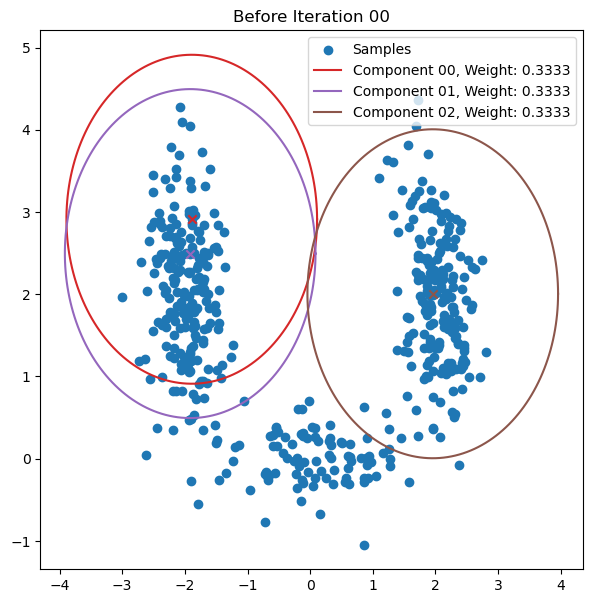

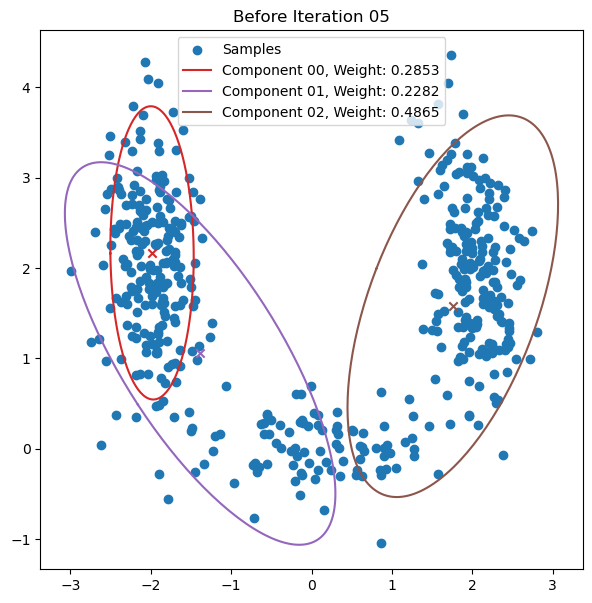

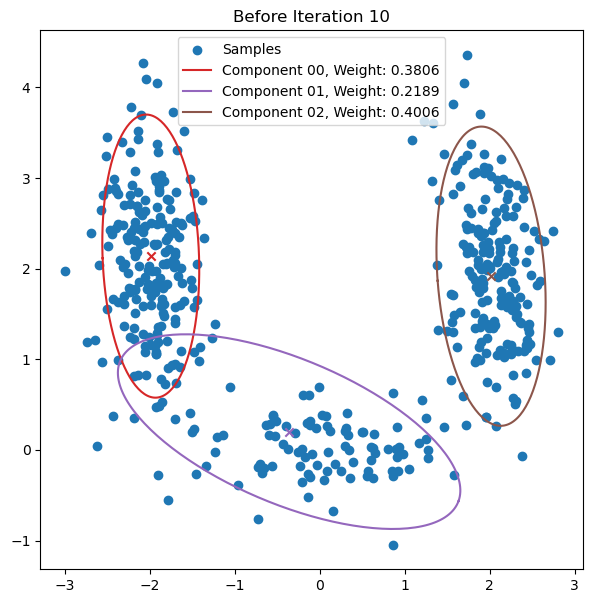

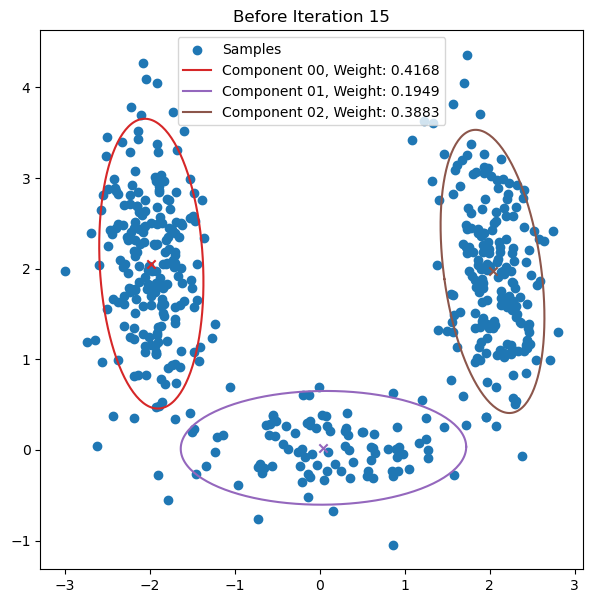

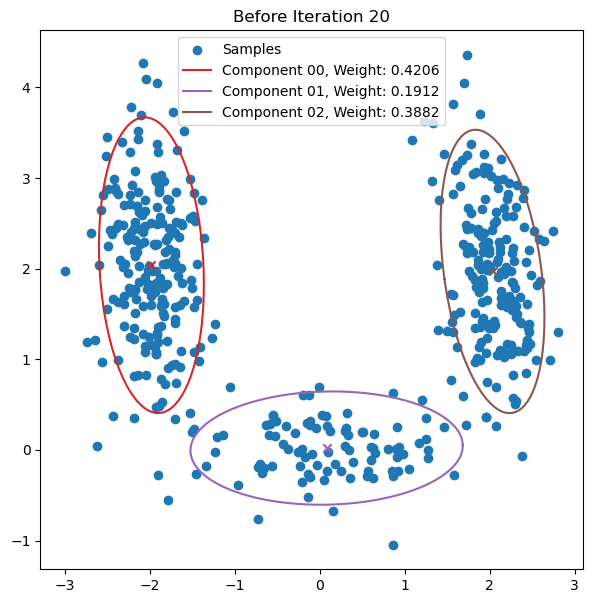

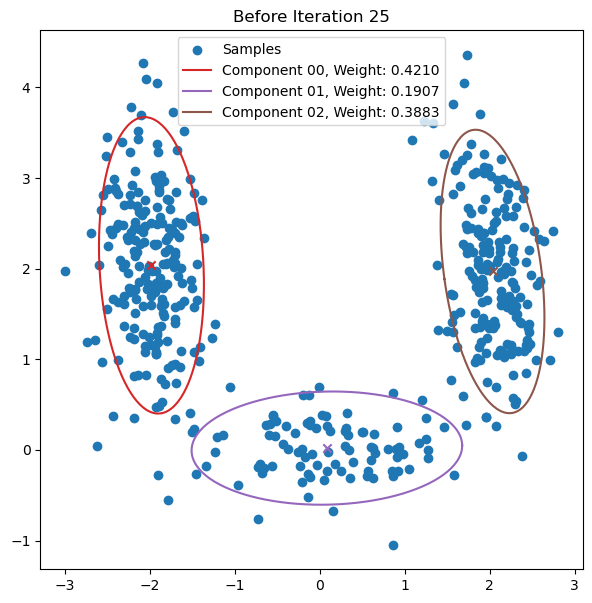

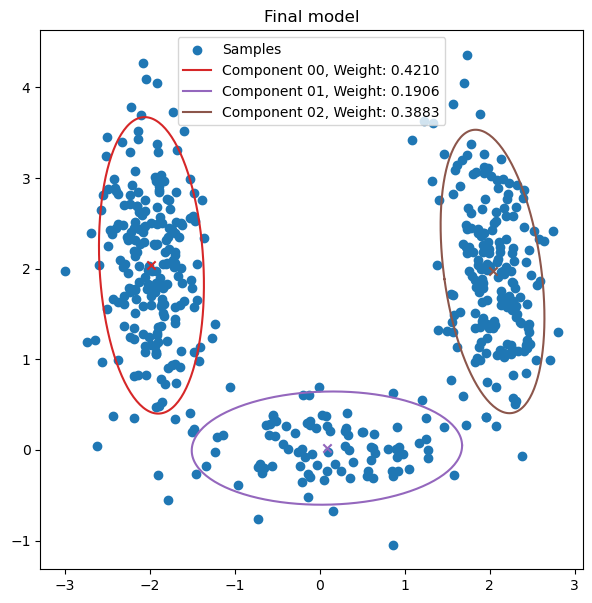

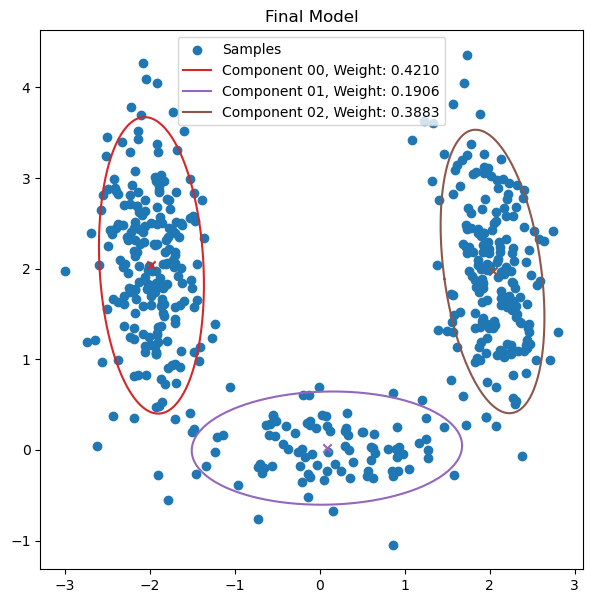

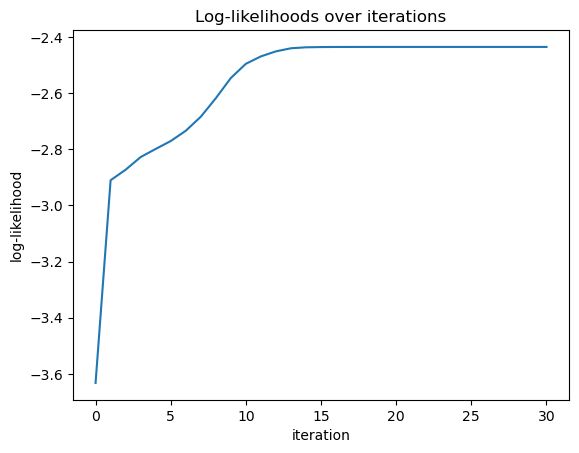

In [7]:
# hyperparameters
seed = 42
num_components = 3
num_iters = 30
vis_interval = 5

# dataset
data = np.load("samples_u.npy")   # choose between samples_1.npy, samples_2.npy, samples_3.npy, samples_u.npy.

# running and ploting
np.random.seed(seed)
final_weights, final_means, final_covariances, log_likeihoods = \
    fit_gaussian_mixture(data, num_components, num_iters, vis_interval)
visualize_2d_gmm(data, final_weights, final_means, final_covariances, title="Final Model")

plt.figure()
plt.title("Log-likelihoods over iterations")
plt.plot(log_likeihoods)
plt.xlabel("iteration")
plt.ylabel("log-likelihood")
plt.show()

## 2. Denoising Diffusion Probabillistic Models (DDPM) (11 Points)
In this exercise, we implement a Denoising Diffusion Probabillistic Models (DDPM). We will test the model on the same (U-shaped) data that we used to train our GMM.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

First, we do some data pre-processing and train-test splits.

In [9]:
X = StandardScaler().fit_transform(data)  # Standardize data

# Split the dataset
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)


Next, we define our denoising model $\epsilon_{\theta}$. Here, we use a simple MLP with a sinusoidal positional embeddings for the time.

In [10]:
# Positional Embeddings for time
class PositionalEmbedding(nn.Module):
    def __init__(self, dim):
        super(PositionalEmbedding, self).__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * (-np.log(10000.0) / half_dim))
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb


# Define the DDPM model as simple MLP with positional embeddings
class DDPM(nn.Module):
    def __init__(self, input_dim, hidden_dim, embed_dim):
        super(DDPM, self).__init__()
        self.fc1 = nn.Linear(input_dim + embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        self.embed = PositionalEmbedding(embed_dim)

    def forward(self, x, t):
        t_embed = self.embed(t)
        x = torch.cat([x, t_embed], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Model hyperparameters
input_dim = 2
hidden_dim = 256
embed_dim = 32

model = DDPM(input_dim, hidden_dim, embed_dim)

Next, we define some parameters associated with the noise schedule. We follow the notation of the lecture and denote the noise schedule parameter as $\alpha_t$, and define $\beta_t = 1 -\alpha_t$ and $ \bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$.

In [11]:
# Define noise schedule
T = 50 # Number of diffusion steps

beta_start = 0.0001
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# Derivation: Forward Process (3 Points)
Recall that the forward process involves gradually adding noise to the data over a series of steps. This is defined as:
$q(x_t \mid x_{t-1}) = \mathcal{N}(x_t; \sqrt{\alpha_t} x_{t-1}, (1 - \alpha_t) I)$
where$ \alpha_t$ is a noise schedule parameter.

From the lecture, we know that we can express$ q(x_t \mid x_0)$ as:
$q(x_t \mid x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I)$
where$ \bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$.

**Exercise**: Show that $q(x_{t-1} \mid x_t, x_0)$ is:

$q(x_{t-1} \mid x_t, x_0) = \mathcal{N}(x_{t-1}; \bar{\mu}_t(x_t, x_0), \bar{\beta}_t I)$

where:
$\bar{\mu}_t(x_t, x_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1}} (1 - \alpha_t)}{1 - \bar{\alpha}_t} x_0$

and
$\bar{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} (1 - \alpha_t)$

**Hint**: It holds that $q(x_t \mid x_{t-1}, x_0) = q(x_t \mid x_{t-1})$.

# Proof: Conditional Distribution in Diffusion Models
There is a nice introduction to diffusion models in https://arxiv.org/pdf/2208.11970, where this derivation can also be found on page 12. Here, we give a slightly different derivation.


We want to show that $q(x_{t-1} | x_t, x_0)$ is:
$q(x_{t-1} | x_t, x_0) = \mathcal{N}(x_{t-1}; \bar{\mu}_t(x_t, x_0), \bar{\beta}_t I)$
where:
$\bar{\mu}_t(x_t, x_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1}} (1 - \alpha_t)}{1 - \bar{\alpha}_t} x_0$
and
$\bar{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} (1 - \alpha_t)$
## Proof
1. We start by applying Bayes' theorem:

   $q(x_{t-1} | x_t, x_0) = \frac{q(x_t | x_{t-1}, x_0) q(x_{t-1} | x_0)}{q(x_t | x_0)}$
   
2. Using the hint that $q(x_t | x_{t-1}, x_0) = q(x_t | x_{t-1})$, we simplify:

   $q(x_{t-1} | x_t, x_0) = \frac{q(x_t | x_{t-1}) q(x_{t-1} | x_0)}{q(x_t | x_0)}$
   
3. We substitute the known distributions:

   $q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{\alpha_t} x_{t-1}, (1 - \alpha_t) I)$
   $q(x_{t-1} | x_0) = \mathcal{N}(x_{t-1}; \sqrt{\bar{\alpha}_{t-1}} x_0, (1 - \bar{\alpha}_{t-1}) I)$
   $q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I)$
   
4. The product of Gaussian distributions is also Gaussian. We can calculate its mean and variance using the precision-weighted sum of the means and precisions of the original distributions.

5. We define the precision (inverse of variance) for each distribution:

   $\Lambda_1 = \frac{1}{1-\alpha_t}I$ (for $q(x_t | x_{t-1})$)
   $\Lambda_2 = \frac{1}{1-\bar{\alpha}_{t-1}}I$ (for $q(x_{t-1} | x_0)$)
   $\Lambda = \frac{1}{1-\bar{\alpha}_t}I$ (for $q(x_t | x_0)$)
   
6. The precision of the resulting distribution:

   $\bar{\Lambda}_t = \Lambda_1 + \Lambda_2 - \Lambda$
   
7. Substituting the values:

   $\bar{\Lambda}_t = (\frac{1}{1-\alpha_t} + \frac{1}{1-\bar{\alpha}_{t-1}} - \frac{1}{1-\bar{\alpha}_t})I$
   
8. The variance $\bar{\beta}_t$ is the inverse of this precision:

   $\bar{\beta}_t = \frac{1}{\frac{1}{1-\alpha_t} + \frac{1}{1-\bar{\alpha}_{t-1}} - \frac{1}{1-\bar{\alpha}_t}}$
   
9. After algebraic manipulation, this simplifies to:

   $\bar{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} (1 - \alpha_t)$
   
10. For the mean, we calculate the precision-weighted mean:

    $\bar{\mu}_t = \bar{\beta}_t (\frac{\sqrt{\alpha_t}}{1-\alpha_t}x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}}{1-\bar{\alpha}_{t-1}}x_0 - \frac{\sqrt{\bar{\alpha}_t}}{1-\bar{\alpha}_t}x_0)$
    
11. After substituting $\bar{\beta}_t$ and simplifying:

    $\bar{\mu}_t = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1}} (1 - \alpha_t)}{1 - \bar{\alpha}_t} x_0$
    
Therefore, we have shown that:
$q(x_{t-1} | x_t, x_0) = \mathcal{N}(x_{t-1}; \bar{\mu}_t(x_t, x_0), \bar{\beta}_t I)$
Where $\bar{\mu}_t$ and $\bar{\beta}_t$ are as given in the problem statement.

## Generate Noisy Samples $x_t$ (2 Point)
In this exercise, we want to implement the DDPM variant where we learn a denoiser $\epsilon_{\theta}(x_t,t)$.
To train the model, we need to generate noisy samples from $q(x_t | x_0)$. We can obtain those by using the reparameterization trick $x_t = \sqrt{\bar \alpha_t x_0} + \sqrt{1-\bar \alpha_t} \epsilon$.


In [12]:
def make_noisy(x_0, t):
    """
    x_0: Batch of samples from the dataset. Shape: (N, D)
    t: Batch of timesteps. Shape (N,)

    Returns:
        epsilon - random noise vector
        x_t - noisy version of x_0
    """
    ####################################
    # # Todo: Generate noisy sample x_t
    #
    # return ...
    ####################################
    # Solution
    noise = torch.randn_like(x_0)  # Random noise
    return noise, torch.sqrt(alpha_bar[t, None]) * x_0 + torch.sqrt(1 - alpha_bar[t, None]) * noise
    ####################################

## Implementing the loss function (2 Point)
Next, we implement the loss function for training the DDPM. The loss function is simply the MSE between the noise vector $\epsilon$ and the predicted noise vector $\epsilon_{\theta}(x_t,t)$, that is $\|\epsilon -\epsilon_{\theta}(x_t,t)\|_2$.

Hint: Use the function you implemented earlier to generate a noisy sample $x_t$.

In [13]:
def ddpm_loss(x_0, t):
    """
    x_0: Batch of samples from the dataset. Shape: (N, D)
    t: Batch of timesteps. Shape (N,)

    Returns:
        Scaler DDPM loss
    """
    loss_fn = nn.MSELoss()
    ####################################
    # # Todo: Implement the loss function
    # return ...
    ####################################
    # Solution
    epsilon, noisy_x = make_noisy(x_0, t)
    predicted_epsilon = model(noisy_x, t.float())
    return loss_fn(predicted_epsilon, epsilon)
    ####################################

Next, we train the DDPM model using the functions that we implemented earlier.

In [14]:
epochs = 200 # Can also train longer for better results!
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size = 128
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for data in train_loader:
        x_0 = data[0]
        t = torch.randint(0, T, (x_0.size(0),), device=x_0.device).long()  # Random timestep for each sample
        loss = ddpm_loss(x_0, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}")

Epoch 1/200, Loss: 0.9978066384792328
Epoch 2/200, Loss: 1.1928786039352417
Epoch 3/200, Loss: 0.9610898047685623
Epoch 4/200, Loss: 0.9705887734889984
Epoch 5/200, Loss: 1.1108336001634598
Epoch 6/200, Loss: 0.8193367272615433
Epoch 7/200, Loss: 0.978875458240509
Epoch 8/200, Loss: 0.8319002091884613
Epoch 9/200, Loss: 0.9322195500135422
Epoch 10/200, Loss: 0.8835557550191879
Epoch 11/200, Loss: 0.8524571359157562
Epoch 12/200, Loss: 0.7953875958919525
Epoch 13/200, Loss: 0.9177374243736267
Epoch 14/200, Loss: 0.883291557431221
Epoch 15/200, Loss: 0.9998889118432999
Epoch 16/200, Loss: 0.8403977006673813
Epoch 17/200, Loss: 0.7995774745941162
Epoch 18/200, Loss: 0.9311607629060745
Epoch 19/200, Loss: 0.8029933720827103
Epoch 20/200, Loss: 0.8124876767396927
Epoch 21/200, Loss: 0.8589185178279877
Epoch 22/200, Loss: 0.8043805807828903
Epoch 23/200, Loss: 0.8835553526878357
Epoch 24/200, Loss: 0.7765931785106659
Epoch 25/200, Loss: 0.7237240076065063
Epoch 26/200, Loss: 0.94667142629623

## Generating Samples (4 Points)

Lastly, we use our trained DDPM model to generate samples. Hence, we have to implement the sample loop. To that end we iteratively denoise a sample $x_T \sim \mathcal{N}(0, 1)$ using
$ x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left(
x_t - \frac{1-\alpha_t}{\sqrt{1-\bar \alpha_t}} \epsilon_{\theta}(x_t,t)
\right) + \sqrt{1-\alpha_t} z$ with $z \sim \mathcal{N}(0,1)$.
Once fully denoised, return the sample $x_0$!

In [15]:
def sample_DDPM(num_samples):
    """
    num_samples: Number of samples to generate from the DDPM
    returns: x_gen_all_t: List containing all x_t
    """
    model.eval()
    with torch.no_grad():
        x_gen_all_t = []
        # Generate new samples
        x_gen = torch.randn((num_samples, 2), device=model.fc1.weight.device)
        x_gen_all_t.append(x_gen.cpu().numpy()) # Convert to numpy for visualization
        for t in reversed(range(T)):
                ####################################
                # # Todo: Implement the denoising loop
                #
     # return x_gen_all_t
                ####################################
                # Solution
                t_tensor = torch.tensor([t], device=x_gen.device, dtype=torch.float32).repeat(num_samples)
                predicted_noise = model(x_gen, t_tensor)

                if t > 0:
                    noise = torch.randn_like(x_gen)
                else:
                    noise = torch.zeros_like(x_gen)

                x_gen = (1/torch.sqrt(alpha[t])) * (x_gen - ((1 - alpha[t]) / (torch.sqrt(1 - alpha_bar[t]))) * predicted_noise)
                x_gen = x_gen + torch.sqrt(beta[t]) * noise
                x_gen_all_t.append(x_gen.cpu().numpy())
                ####################################

    return x_gen_all_t  # Convert to numpy for visualization


Lastly, we generate samples and visualize them!

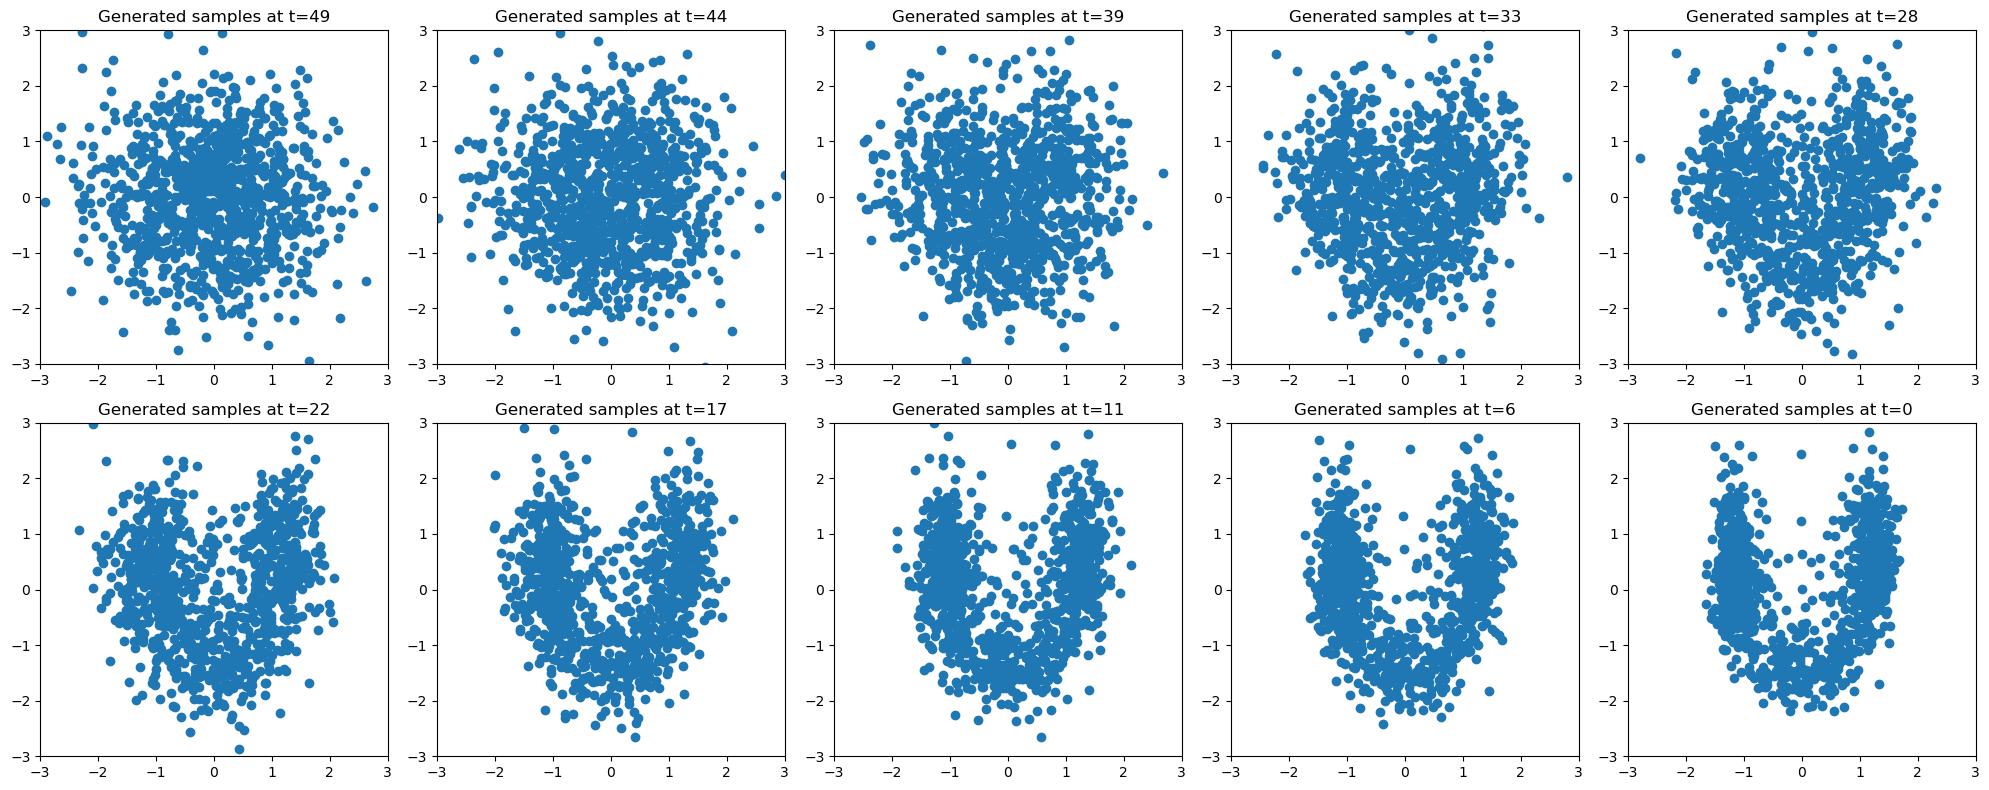

In [16]:
samples = sample_DDPM(1000)


indices = np.linspace(0, T-1, 10, dtype=int)

# Create a 2x5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Plot the selected samples
for i, idx in enumerate(indices):
    ax = axes[i // 5, i % 5]
    ax.scatter(samples[idx][:, 0], samples[idx][:, 1])
    ax.set_title(f'Generated samples at t={T-idx-1}')
    ax.set_xlim(-3, 3)  # Adjust limits if necessary
    ax.set_ylim(-3, 3)  # Adjust limits if necessary

plt.tight_layout()
plt.show()